## 0. Problem statement
In the telecom industry, customers are able to choose from multiple service providers and actively switch from one operator to another. In this highly competitive market, the telecommunications industry experiences an average of 15-25% annual churn rate. Given the fact that it costs 5-10 times more to acquire a new customer than to retain an existing one, customer retention has now become even more important than customer acquisition.

For many incumbent operators, retaining high profitable customers is the number one business goal. To reduce customer churn, telecom companies need to predict which customers are at high risk of churn. In this project, you will analyze customer-level data of a leading telecom firm, build predictive models to identify customers at high risk of churn, and identify the main indicators of churn.

In this competition, your goal is to build a machine learning model that is able to predict churning customers based on the features provided for their usage.

Customer behaviour during churn:

Customers usually do not decide to switch to another competitor instantly, but rather over a period of time (this is especially applicable to high-value customers). In churn prediction, we assume that there are three phases of customer lifecycle :

The ‘good’ phase: In this phase, the customer is happy with the service and behaves as usual.

The ‘action’ phase: The customer experience starts to sore in this phase, for e.g. he/she gets a compelling offer from a competitor, faces unjust charges, becomes unhappy with service quality etc. In this phase, the customer usually shows different behaviour than the ‘good’ months. It is crucial to identify high-churn-risk customers in this phase, since some corrective actions can be taken at this point (such as matching the competitor’s offer/improving the service quality etc.)

The ‘churn’ phase: In this phase, the customer is said to have churned. In this case, since you are working over a four-month window, the first two months are the ‘good’ phase, the third month is the ‘action’ phase, while the fourth month (September) is the ‘churn’ phase.

## 1. Loading dependencies & datasets

Lets start by loading our dependencies. We can keep adding any imports to this cell block, as we write mode and mode code.

In [165]:
#Data Structures
import pandas as pd
import numpy as np
#Sklearn

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix, precision_score, recall_score,accuracy_score
from sklearn.svm import SVC
from sklearn.impute import SimpleImputer
#Plotting
import matplotlib.pyplot as plt
import seaborn as sns


Next, we load our datasets and the data dictionary file.

The **train.csv** file contains both dependent and independent features, while the **test.csv** contains only the independent variables. 

So, for model selection, I will create our own train/test dataset from the **train.csv** and use the model to predict the solution using the features in unseen test.csv data for submission.

In [2]:
data = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")
sample = pd.read_csv("sample.csv")
data_dict = pd.read_csv("data_dictionary.csv")

print(data.shape)
print(test.shape)
print(sample.shape)
print(data_dict.shape)

(69999, 172)
(30000, 171)
(30000, 2)
(36, 2)


In [3]:
data_dict

,Acronyms,Description
0,CIRCLE_ID,Telecom circle area to which the customer belo...
1,LOC,Local calls within same telecom circle
2,STD,STD calls outside the calling circle
3,IC,Incoming calls
4,OG,Outgoing calls
5,T2T,Operator T to T ie within same operator mobile...
6,T2M,Operator T to other operator mobile
7,T2O,Operator T to other operator fixed line
8,T2F,Operator T to fixed lines of T
9,T2C,Operator T to its own call center


In [4]:
data.head()

,id,circle_id,loc_og_t2o_mou,std_og_t2o_mou,loc_ic_t2o_mou,last_date_of_month_6,last_date_of_month_7,last_date_of_month_8,arpu_6,arpu_7,...,sachet_3g_7,sachet_3g_8,fb_user_6,fb_user_7,fb_user_8,aon,aug_vbc_3g,jul_vbc_3g,jun_vbc_3g,churn_probability
0,0,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,31.277,87.009,...,0,0,NaN,NaN,NaN,1958,0.0,0.0,0.0,0
1,1,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,0.000,122.787,...,0,0,NaN,1.0,NaN,710,0.0,0.0,0.0,0
2,2,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,60.806,103.176,...,0,0,NaN,NaN,NaN,882,0.0,0.0,0.0,0
3,3,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,156.362,205.260,...,0,0,NaN,NaN,NaN,982,0.0,0.0,0.0,0
4,4,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,240.708,128.191,...,1,0,1.0,1.0,1.0,647,0.0,0.0,0.0,0


In [5]:
data.info(verbose=1)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 69999 entries, 0 to 69998
Data columns (total 172 columns):
 #    Column                    Dtype  
---   ------                    -----  
 0    id                        int64  
 1    circle_id                 int64  
 2    loc_og_t2o_mou            float64
 3    std_og_t2o_mou            float64
 4    loc_ic_t2o_mou            float64
 5    last_date_of_month_6      object 
 6    last_date_of_month_7      object 
 7    last_date_of_month_8      object 
 8    arpu_6                    float64
 9    arpu_7                    float64
 10   arpu_8                    float64
 11   onnet_mou_6               float64
 12   onnet_mou_7               float64
 13   onnet_mou_8               float64
 14   offnet_mou_6              float64
 15   offnet_mou_7              float64
 16   offnet_mou_8              float64
 17   roam_ic_mou_6             float64
 18   roam_ic_mou_7             float64
 19   roam_ic_mou_8             float64
 20   roam

In [6]:
data.describe()

,id,circle_id,loc_og_t2o_mou,std_og_t2o_mou,loc_ic_t2o_mou,arpu_6,arpu_7,arpu_8,onnet_mou_6,onnet_mou_7,...,sachet_3g_7,sachet_3g_8,fb_user_6,fb_user_7,fb_user_8,aon,aug_vbc_3g,jul_vbc_3g,jun_vbc_3g,churn_probability
count,69999.000000,69999.0,69297.0,69297.0,69297.0,69999.000000,69999.000000,69999.000000,67231.000000,67312.000000,...,69999.000000,69999.000000,17568.000000,17865.000000,18417.000000,69999.000000,69999.000000,69999.000000,69999.00000,69999.000000
mean,34999.000000,109.0,0.0,0.0,0.0,283.134365,278.185912,278.858826,133.153275,133.894438,...,0.081444,0.085487,0.916325,0.909544,0.890319,1220.639709,68.108597,65.935830,60.07674,0.101887
std,20207.115084,0.0,0.0,0.0,0.0,334.213918,344.366927,351.924315,299.963093,311.277193,...,0.634547,0.680035,0.276907,0.286842,0.312501,952.426321,269.328659,267.899034,257.22681,0.302502
min,0.000000,109.0,0.0,0.0,0.0,-2258.709000,-1289.715000,-945.808000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,180.000000,0.000000,0.000000,0.00000,0.000000
25%,17499.500000,109.0,0.0,0.0,0.0,93.581000,86.714000,84.095000,7.410000,6.675000,...,0.000000,0.000000,1.000000,1.000000,1.000000,468.000000,0.000000,0.000000,0.00000,0.000000
50%,34999.000000,109.0,0.0,0.0,0.0,197.484000,191.588000,192.234000,34.110000,32.280000,...,0.000000,0.000000,1.000000,1.000000,1.000000,868.000000,0.000000,0.000000,0.00000,0.000000
75%,52498.500000,109.0,0.0,0.0,0.0,370.791000,365.369500,369.909000,119.390000,115.837500,...,0.000000,0.000000,1.000000,1.000000,1.000000,1813.000000,0.000000,0.000000,0.00000,0.000000
max,69998.000000,109.0,0.0,0.0,0.0,27731.088000,35145.834000,33543.624000,7376.710000,8157.780000,...,33.000000,41.000000,1.000000,1.000000,1.000000,4337.000000,12916.220000,9165.600000,11166.21000,1.000000


In [7]:
test.head()

,id,circle_id,loc_og_t2o_mou,std_og_t2o_mou,loc_ic_t2o_mou,last_date_of_month_6,last_date_of_month_7,last_date_of_month_8,arpu_6,arpu_7,...,sachet_3g_6,sachet_3g_7,sachet_3g_8,fb_user_6,fb_user_7,fb_user_8,aon,aug_vbc_3g,jul_vbc_3g,jun_vbc_3g
0,69999,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,91.882,65.330,...,0,0,0,NaN,NaN,NaN,1692,0.00,0.00,0.00
1,70000,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,414.168,515.568,...,0,0,0,NaN,NaN,NaN,2533,0.00,0.00,0.00
2,70001,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,329.844,434.884,...,0,0,0,NaN,NaN,NaN,277,525.61,758.41,241.84
3,70002,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,43.550,171.390,...,0,0,0,NaN,NaN,NaN,1244,0.00,0.00,0.00
4,70003,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,306.854,406.289,...,0,0,0,NaN,NaN,NaN,462,0.00,0.00,0.00


In [8]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30000 entries, 0 to 29999
Columns: 171 entries, id to jun_vbc_3g
dtypes: float64(135), int64(27), object(9)
memory usage: 39.1+ MB


## 2. Data Analysis
1. formatting: The date columns were having 'object' as their data type, we have converted to the proper datetime format.
2. Checked for missing values. Dropped all the columns with missing values greater than 50%.  
3. Checking for duplicate records (rows) in the data. There were no duplicates.Some columns had similar range of missing values. So, we have looked at their related columns and checked if these might be imputed with zero.  
4. .Since, our analysis is focused on the HVC(High value customers), we have filtered for high value customers to carryout the further analysis. The metric of this filtering of HVC is such that all the customers whose 'Average_rech_amt' of months 6 and 7 greater than or equal to 70th percentile of the 'Average_rech_amt' are considered as High Value Customers.   
 
  

In [9]:
#formatting date time values-test and train dataset
print(data.select_dtypes(include='object').columns)

Index(['last_date_of_month_6', 'last_date_of_month_7', 'last_date_of_month_8',
       'date_of_last_rech_6', 'date_of_last_rech_7', 'date_of_last_rech_8',
       'date_of_last_rech_data_6', 'date_of_last_rech_data_7',
       'date_of_last_rech_data_8'],
      dtype='object')


In [10]:
data_cols=data.select_dtypes(include='object')

In [11]:
for i in data_cols.columns:
    data[i] = pd.to_datetime(data[i])

#Impute

In [12]:
#Impute 
data_new = data.copy()

data_new['av_rech_amt_data_6'] = data['av_rech_amt_data_6'].fillna(0)
data_new['av_rech_amt_data_7'] = data['av_rech_amt_data_7'].fillna(0)
data_new['av_rech_amt_data_8'] = data['av_rech_amt_data_8'].fillna(0)
data_new['total_rech_amt_6'] = data['total_rech_amt_6'].fillna(0) 
data_new['total_rech_amt_7'] = data['total_rech_amt_7'].fillna(0)
data_new['total_rech_amt_8'] = data['total_rech_amt_8'].fillna(0)

In [13]:
#find total amount spent by customers on data recharge

In [14]:
data_new['total_data_rech_6'] = data_new.total_rech_data_6 * data_new.av_rech_amt_data_6
data_new['total_data_rech_7'] = data_new.total_rech_data_7 * data_new.av_rech_amt_data_7

In [15]:
#dropping not needed fields now we have total amount
data_new.drop(['av_rech_amt_data_6','av_rech_amt_data_7','av_rech_amt_data_8',
'total_rech_amt_8'],axis = 1,inplace = True)

# <b>drop null rows  Since too much missing information would make a column not really a great predictor for churn, 
#we drop these columns and keep only the ones which have less than 50% missing data.

In [16]:
100*(data_new.isnull().sum()/len(data_new)).sort_values(ascending=False)

max_rech_data_6             74.902499
total_data_rech_6           74.902499
date_of_last_rech_data_6    74.902499
fb_user_6                   74.902499
total_rech_data_6           74.902499
                              ...    
vol_2g_mb_7                  0.000000
vol_2g_mb_8                  0.000000
vol_3g_mb_6                  0.000000
vol_3g_mb_7                  0.000000
id                           0.000000
Length: 170, dtype: float64

In [17]:
missing_percent=100*(data_new.isnull().sum()/len(data_new))
data_new=data_new.loc[:,missing_percent <= 50]

In [18]:
data_new.shape

(69999, 141)

In [19]:
test.shape

(30000, 171)

In [20]:
(data_new.isnull().sum()/len(data_new)).sort_values(ascending=False)

loc_ic_t2m_mou_8      0.052901
loc_og_t2t_mou_8      0.052901
loc_og_t2f_mou_8      0.052901
loc_og_t2c_mou_8      0.052901
loc_og_mou_8          0.052901
                        ...   
max_rech_amt_6        0.000000
max_rech_amt_7        0.000000
max_rech_amt_8        0.000000
last_day_rch_amt_6    0.000000
churn_probability     0.000000
Length: 141, dtype: float64

In [21]:
data_new.nunique().sort_values()

std_ic_t2o_mou_7        1
circle_id               1
loc_og_t2o_mou          1
std_og_t2o_mou          1
loc_ic_t2o_mou          1
                    ...  
total_og_mou_7      33195
arpu_8              60194
arpu_7              61425
arpu_6              61615
id                  69999
Length: 141, dtype: int64

## drop 1 unique value as there is no value add


In [22]:
data_new=data_new.loc[:,data_new.nunique() > 1]

In [23]:
data_new.nunique().sort_values()

churn_probability        2
monthly_2g_6             5
monthly_2g_7             6
monthly_2g_8             6
monthly_3g_6            10
                     ...  
total_og_mou_7       33195
arpu_8               60194
arpu_7               61425
arpu_6               61615
id                   69999
Length: 128, dtype: int64

## Derived variable

In [24]:
#find HVC customer:#Customers are High Values if their Average recharge amount of june and july is more than or equal to 70th percentile 
#of Average recharge amount.

In [25]:
data_new['avg_rech_amt_6_7'] = (data_new['total_rech_amt_6'] + data_new['total_rech_amt_7'])/2
data_new=data_new[(data_new['avg_rech_amt_6_7']>= data_new['avg_rech_amt_6_7'].quantile(0.7))]

In [26]:
data_new.shape

(21018, 129)

#The total number of customers is now limited to ~20k 
#who lies under the High Value customer criteria basen upon which the model is built.

In [27]:
data_new=data_new.drop(columns=['total_rech_amt_6', 'total_rech_amt_7','avg_rech_amt_6_7'],axis=1)

In [28]:
#USAGE-CALLS

In [29]:
round(100*(data_new['churn_probability'].mean()),2)

8.84

#there is little possiblity of churn in HVC

## 3. EDA
Analysis Steps

EDA

1.The telecom company has many users with negative average revenues in both phases. These users are likely to churn.

2.Revenue generated by the Customers who are about to churn is very unstable.

3.The Customers whose arpu decreases in 7th month are more likely to churn when compared to ones with increase in arpu.

4.The Customers with high total_og_mou in 6th month and lower total_og_mou in 7th month are more likely to churn compared to the rest.

5.The Customers with decrease in rate of total_ic_mou in 7th month are more likely to churn, compared to the rest.

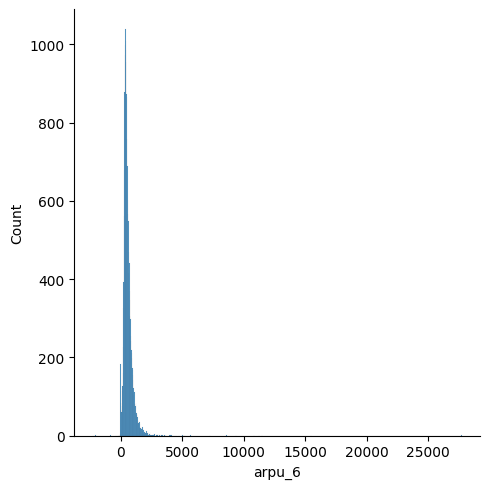

In [30]:
sns.displot(data_new.arpu_6)

In [31]:
#Most of average revenue per user is less than 2500 for June month.

<Axes: xlabel='onnet_mou_8', ylabel='Count'>

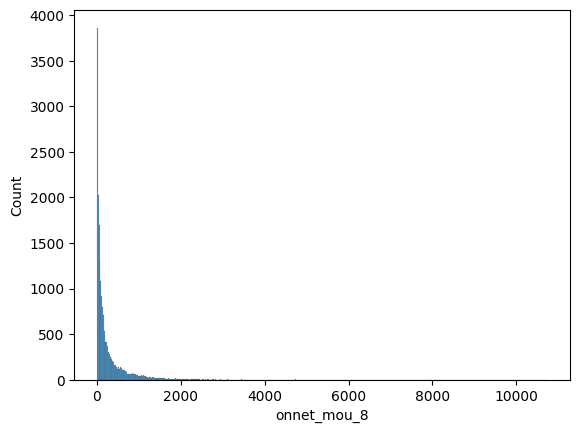

In [32]:
sns.histplot(data_new.onnet_mou_8)

In [33]:
# around 500calls were made withn smae network in august

In [34]:
# creating a new variable 'tenure'
data_new['tenure'] = (data_new['aon']/30).round(0)
# Since we derived a new column from 'aon', we can drop it
data_new.drop('aon',axis=1, inplace=True)

In [35]:
data_new.shape

(21018, 126)

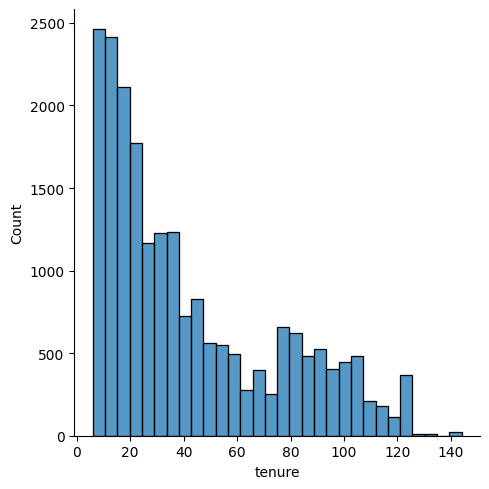

In [36]:
# Checking the distribution of he tenure variable

sns.displot(data_new['tenure'],bins=30)
plt.show()

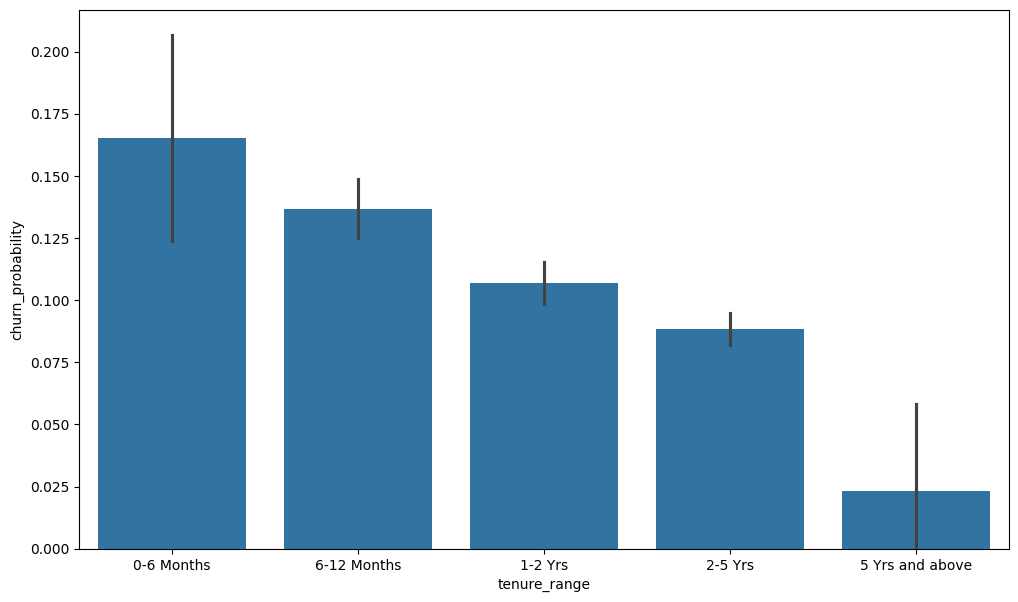

In [37]:
tn_range = [0, 6, 12, 24, 60, 61]
tn_label = [ '0-6 Months', '6-12 Months', '1-2 Yrs', '2-5 Yrs', '5 Yrs and above']
data_new['tenure_range'] = pd.cut(data_new['tenure'], tn_range, labels=tn_label)
plt.figure(figsize=[12,7])
sns.barplot(x='tenure_range',y='churn_probability', data=data_new)
plt.show()

In [38]:
#It can be seen that the maximum churn rate happens within 0-6 month, 
#but it gradually decreases as the customer retains in the network.

In [39]:
data_new.drop(columns=['tenure_range'], axis=1, inplace=True)

<Axes: >

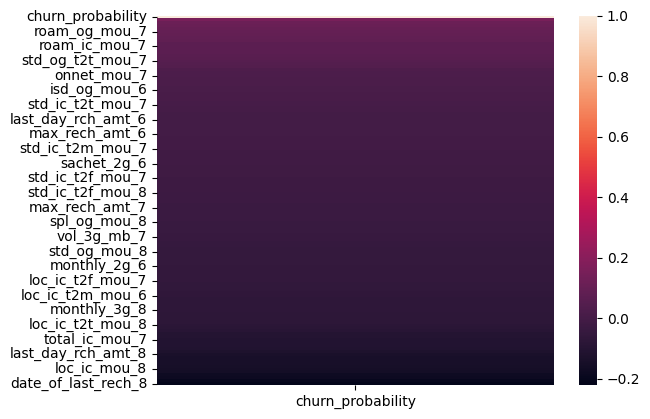

In [40]:
sns.heatmap(data_new.corr()[['churn_probability']].sort_values(ascending=False,by='churn_probability'))

In [41]:
#Features postively impacting churn rate  
#1. Roaming incoming and outgoing for July month
#2. date of last recharge for June month
#3. max rechage amount for June month
#Features negatiely impacting churn rate 
#1. date of last recharge for August
#2. total number of incoming calls for July.

In [42]:
#Derive new features
#Decrease Mou-This column indicates whether the minutes of usage of the customer has decreased
data_new['total_mou_good'] = (data_new['total_og_mou_6'] + data_new['total_ic_mou_6'])
data_new['avg_mou_action'] = (data_new['total_og_mou_7'] + data_new['total_og_mou_8'] + data_new['total_ic_mou_7'] + data_new['total_ic_mou_8'])/2
data_new['diff_mou'] = data_new['avg_mou_action'] - data_new['total_mou_good']
data_new['decrease_mou_action'] = np.where((data_new['diff_mou'] < 0), 1, 0)


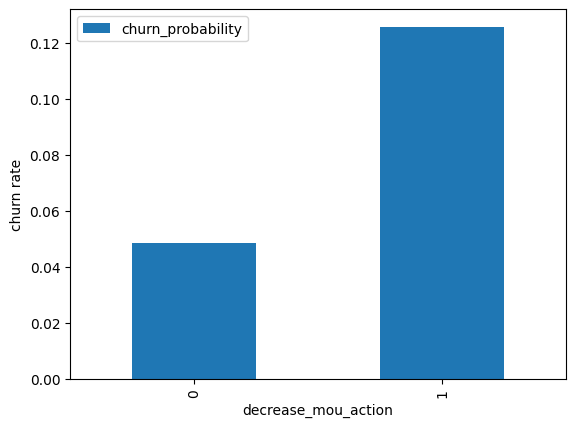

In [43]:
data_new.pivot_table(values='churn_probability', index='decrease_mou_action', aggfunc='mean').plot.bar()
plt.ylabel('churn rate')
plt.show()

In [44]:
#Churn rate on the basis whether the customer decreased her/his call usage.
#the churn rate is more for the customers, whose minutes of usage(mou) decreased

In [45]:
#Decrease volume based on cost
#This column indicates whether the volume based cost of the customer has decreased 
data_new['avg_vbc_3g_action'] = (data_new['jul_vbc_3g'] + data_new['aug_vbc_3g'])/2
data_new['diff_vbc'] = data_new['avg_vbc_3g_action'] - data_new['jun_vbc_3g']
data_new['decrease_vbc_action'] = np.where(data_new['diff_vbc'] < 0 , 1, 0)

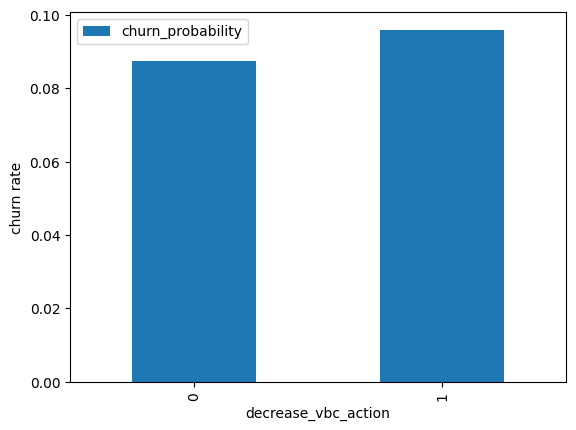

In [46]:
#Churn rate on the basis whether the customer decreased her/his MOU

data_new.pivot_table(values='churn_probability', index='decrease_vbc_action', aggfunc='mean').plot.bar()
plt.ylabel('churn rate')
plt.show()

In [47]:
# churn rate is more for the customers, whose number of recharge in the action phase is lesser
# Not much of difference

In [48]:
#Decrease rech-num-This column indicates whether the number of recharge of the customer has decreased
data_new['avg_rech_num_action'] = (data_new['total_rech_num_7'] + data_new['total_rech_num_8'])/2
data_new['diff_rech_num'] = data_new['avg_rech_num_action'] - data_new['total_rech_num_6']
data_new['decrease_rech_num_action'] = np.where((data_new['diff_rech_num'] < 0), 1, 0)

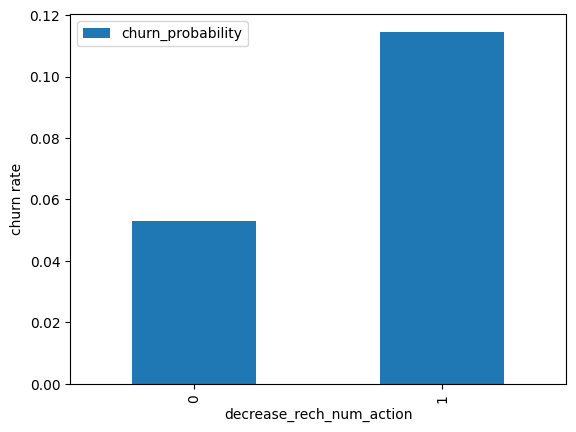

In [49]:
data_new.pivot_table(values='churn_probability', index='decrease_rech_num_action', aggfunc='mean').plot.bar()
plt.ylabel('churn rate')
plt.show()
# churn rate is more for the customers, whose amount of recharge in the action phase is lesser 

In [50]:
data_new= data_new.drop(columns=['total_mou_good','avg_mou_action','diff_mou','avg_rech_num_action','diff_rech_num',
                 'avg_vbc_3g_action','diff_vbc','tenure','date_of_last_rech_6','date_of_last_rech_7','date_of_last_rech_8',
                 'arpu_6','arpu_7','arpu_8','id'],axis=1)                

In [51]:
data_new= data_new.drop(columns=['decrease_mou_action', 'decrease_vbc_action', 'decrease_rech_num_action'],axis=1)

In [52]:
data_new.isna().sum()

onnet_mou_6          223
onnet_mou_7          208
onnet_mou_8          655
offnet_mou_6         223
offnet_mou_7         208
                    ... 
sachet_3g_8            0
aug_vbc_3g             0
jul_vbc_3g             0
jun_vbc_3g             0
churn_probability      0
Length: 118, dtype: int64

In [53]:
data_new = data_new.dropna()

In [54]:
data_new.shape

(20206, 118)

# 4. Create X, y and then Train test split


In [55]:
X=data_new.drop(columns=['churn_probability'],axis=1)
y=data_new.churn_probability

In [56]:
X_train,X_test,y_train,y_test=train_test_split(X,y,train_size=0.7,random_state=100,stratify=y)

In [57]:
X_train.shape

(14144, 117)

In [58]:
X_test.shape

(6062, 117)

In [59]:
y_test.shape

(6062,)

# 5. Feature engineering and selection

Let's understand feature importances for raw features as well as components to decide top features for modelling.

In [60]:
std=StandardScaler()
X_train_scaled=std.fit_transform(X_train)
X_test_scaled=std.transform(X_test)

In [61]:
X_train_scaled.shape

(14144, 117)

In [62]:
logm1=LogisticRegression()
logm1.fit(X_train_scaled, y_train)
y_pred = logm1.predict(X_test_scaled)
accuracy_score(y_pred,y_test)


/opt/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


0.9346750247443089

In [63]:
recall_score(y_pred,y_test)

0.45054945054945056

In [64]:
svc=SVC(C=1)

In [65]:
svc.fit(X_train_scaled, y_train)
y_pred_svc = svc.predict(X_test_scaled)
accuracy_score(y_pred_svc,y_test)

0.9361596832728473

In [66]:
recall_score(y_pred_svc,y_test,average='macro')

/opt/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


0.46807984163642363

In [67]:
rfe=RandomForestClassifier(n_jobs = -1)
rfe.fit(X_train_scaled,y_train)
y_pred_rfe=rfe.predict(X_test_scaled)


In [68]:
accuracy_score(y_pred_rfe,y_test)

0.9424282415044539

In [69]:
recall_score(y_pred_rfe,y_test)

0.6144578313253012

#Highest accuracy score is 94.19% so model building and pca ,hyper parameter will be on RFE

In [92]:
### Model                      Accuracy   |   Recall
##  SVC -- >                     93.61%   |   46.8%
##  RFE-->                       94.24%   |   61.4%
##  LogisticRegression           93.46%    |   45%
##  RFE+pca                      94.2%  |    61%

In [71]:

pipe = Pipeline(steps=[
    ('std', StandardScaler()),
    ('pca', PCA()),
    ('rfe', RandomForestClassifier(n_jobs=-1))
])


In [72]:
pipe.fit(X_train,y_train)
y_pred_pipe=pipe.predict(X_test)

In [102]:
pipe.named_steps.pca.n_components

89

In [74]:
pipe.named_steps.rfe.get_params

<bound method BaseEstimator.get_params of RandomForestClassifier(n_jobs=-1)>

In [75]:
accuracy_score(y_pred_rfe,y_test)

0.9424282415044539

In [76]:
recall_score(y_pred_rfe,y_test)

0.6144578313253012

In [77]:
pca=pipe.named_steps['pca']

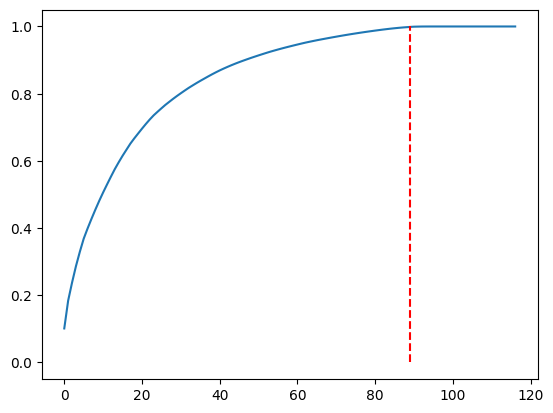

In [78]:
var_cum=np.cumsum(pca.explained_variance_ratio_)
plt.plot(var_cum)
plt.vlines(x=89, ymax=1, ymin=0, colors="r", linestyles="--")

In [79]:
PCA_VARS = 89

In [80]:
# Define hyperparameter space
param_grid = {
    'n_estimators': [100,200,400,700],
    'max_depth': [None, 10, 20,30],
    'min_samples_split': [10,20,30],

}

In [81]:
gridsearch=GridSearchCV(RandomForestClassifier(), param_grid, cv=5, n_jobs=-1,verbose=1)

In [82]:
gridsearch.fit(X_train_scaled,y_train)

Fitting 5 folds for each of 48 candidates, totalling 240 fits


GridSearchCV(cv=5, estimator=RandomForestClassifier(), n_jobs=-1,
             param_grid={'max_depth': [None, 10, 20, 30],
                         'min_samples_split': [10, 20, 30],
                         'n_estimators': [100, 200, 400, 700]},
             verbose=1)

In [93]:
gridsearch.best_params_

{'max_depth': 20, 'min_samples_split': 30, 'n_estimators': 100}

In [98]:

pipe = Pipeline(steps=[
    ('std', StandardScaler()),
    ('pca', PCA(n_components=89)),
    ('rfe', RandomForestClassifier(max_depth=20, min_samples_split=30, n_estimators=100,n_jobs=-1))
])


In [99]:
pipe.fit(X_train,y_train)
y_pred_pipe1=pipe.predict(X_test)

In [100]:
accuracy_score(y_pred_pipe1,y_test)

0.9359947212141208

In [101]:
recall_score(y_pred_pipe1,y_test)

0.42857142857142855

# 6. Model building

Let's build a quick model with logistic regression and the first 2 PCA components.

In [106]:
rfe1=RandomForestClassifier(n_jobs = -1)
rfe1.fit(X_train,y_train)
y_pred_rfe1=rfe1.predict(X_test)

In [107]:
accuracy_score(y_pred_rfe1,y_test)

0.9429231276806335

In [108]:
recall_score(y_pred_rfe1,y_test)

0.6171428571428571

## 7. Create Submission File
For submission, we need to make sure that the format is exactly the same as the sample.csv file. It contains 2 columns, id and churn_probability

In [152]:
sample.head()

,id,churn_probability
0,69999,0
1,70000,0
2,70001,0
3,70002,0
4,70003,0


In [153]:
test.head()

,id,circle_id,loc_og_t2o_mou,std_og_t2o_mou,loc_ic_t2o_mou,last_date_of_month_6,last_date_of_month_7,last_date_of_month_8,arpu_6,arpu_7,...,sachet_3g_6,sachet_3g_7,sachet_3g_8,fb_user_6,fb_user_7,fb_user_8,aon,aug_vbc_3g,jul_vbc_3g,jun_vbc_3g
0,69999,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,91.882,65.330,...,0,0,0,NaN,NaN,NaN,1692,0.00,0.00,0.00
1,70000,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,414.168,515.568,...,0,0,0,NaN,NaN,NaN,2533,0.00,0.00,0.00
2,70001,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,329.844,434.884,...,0,0,0,NaN,NaN,NaN,277,525.61,758.41,241.84
3,70002,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,43.550,171.390,...,0,0,0,NaN,NaN,NaN,1244,0.00,0.00,0.00
4,70003,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,306.854,406.289,...,0,0,0,NaN,NaN,NaN,462,0.00,0.00,0.00


In [159]:
submission_data=test.set_index('id')[X_train.columns]
submission_data.shape

(30000, 117)

In [166]:
imputer = SimpleImputer(strategy='mean')
submission_data_imputed = pd.DataFrame(imputer.fit_transform(submission_data), columns=X_train.columns)

In [168]:
test['churn_probability'] = rfe1.predict(submission_data_imputed)
output = test[['id','churn_probability']]
output.head()

,id,churn_probability
0,69999,0
1,70000,0
2,70001,1
3,70002,0
4,70003,0


In [169]:
output.to_csv('submission.csv',index=False)

## Recommendations



#Target the customers, whose minutes of usage of the incoming local calls and outgoing ISD calls are less in the action phase (mostly in the month of August). 
#Target the customers, whose outgoing others charge in July and incoming others on August are less. 
#the customers having value based cost in the action phase increased are more likely to churn than the other customers. Hence, these customers may be a good target to provide offer. 
#Customers having decreasing incoming minutes of usage for operators T to fixed lines of T for August are more likely to churn. 
